# YOLO
In yolo (you only look once) we will have B bounding boxes per pixel, and the pixels are large and cover the whole image.

The pixel in which the center of an object lies is responsible for detecting the object.

Each of the bounding boxes output is 5 numbers, (x,y) (the center, not corner) width, height, confidence.

Confidence is a prediction of IOU

Additionally, each cell predicts a probability distribution over class labels.




# Color module
We can use my attention mechanism to give some sort of a color module.

Say I have a variable number of colors N, and I want to map to a fixed number M.

We get M convolution filters.

We filter each image with each filter.  This gives an N x M array of images.

We then apply a softmax to it.  We then do matrix multiplication.



# TODO
use running mean batch norm

fix rotated bounding boxes

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from matplotlib.collections import PolyCollection
# %matplotlib notebook
%matplotlib widget
from os import makedirs
from os.path import join
import time
from scipy.ndimage import gaussian_filter

user = 'abenneck'
# user = 'dtward'

import sys
sys.path.append('/home/abenneck/Desktop/yolo_model')

from yolo_help import iou

In [2]:
resume = True # if True, will load a saved model
if user == 'abenneck':
    outdir = '/home/abenneck/Desktop/YOLO/yolo_saved_models_v01'
else:
    outdir = 'yolo_saved_models_v01'
modelname = 'modelsave.pt'
optimizername = 'optimizersave.pt'
lossname = 'loss.pt'
makedirs(outdir,exist_ok=True)

nclasses = 3
dtype = torch.float32

In [3]:
from yolo_help import GroundTruthDataset


groundtruth = GroundTruthDataset(reproducible = True)

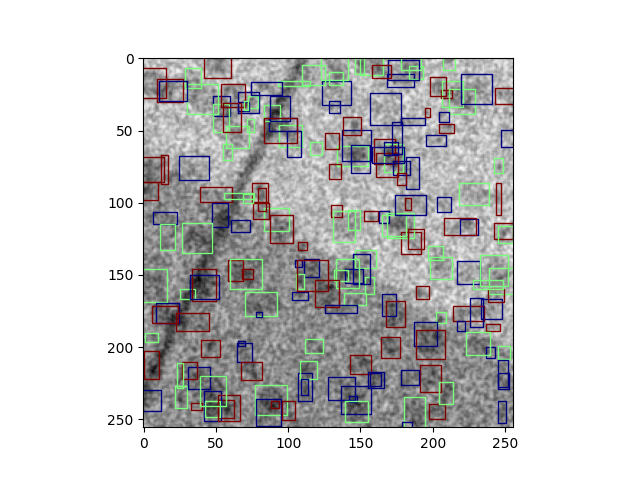

In [4]:
from yolo_help import bbox_to_rectangles, imshow


I,bbox,cl = groundtruth[0]
fig,ax = plt.subplots()
#ax.imshow(I[0],cmap='gray')
imshow(I,ax,cmap='gray')
polys = bbox_to_rectangles(bbox,fc='none')
polys.set_edgecolor(plt.cm.jet(cl*255//(nclasses-1)))
ax.add_collection(polys)

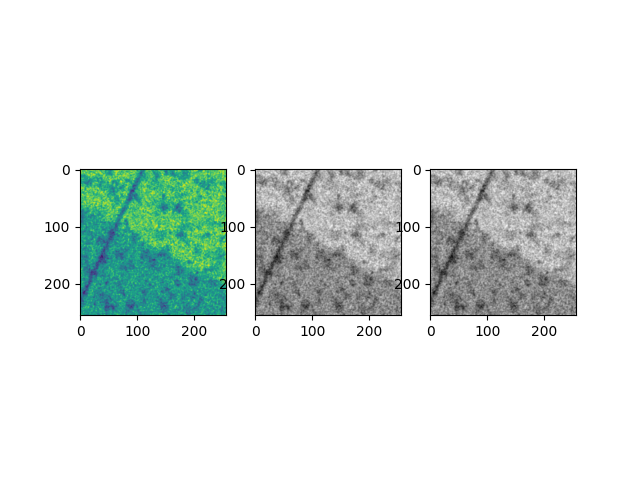

In [5]:
from yolo_help import VariableInputConv2d


layer = VariableInputConv2d(3)
fig,ax = plt.subplots(1,3)
I,bbox,cls = groundtruth[0]
imshow(I,ax[0])

r = torch.randperm(I.shape[0])
out1 = layer(torch.tensor(I,dtype=dtype)[None]).clone().detach()[0]
out2 = layer(torch.tensor(I,dtype=dtype)[r][None]).clone().detach()[0] 
imshow(out1,ax[1])
imshow(out2,ax[2])
# note the order of components doesn't matter

In [6]:
from yolo_help import Net


net = Net()
out = net(torch.tensor(I[None],dtype=dtype))
out.shape

torch.Size([1, 13, 32, 32])

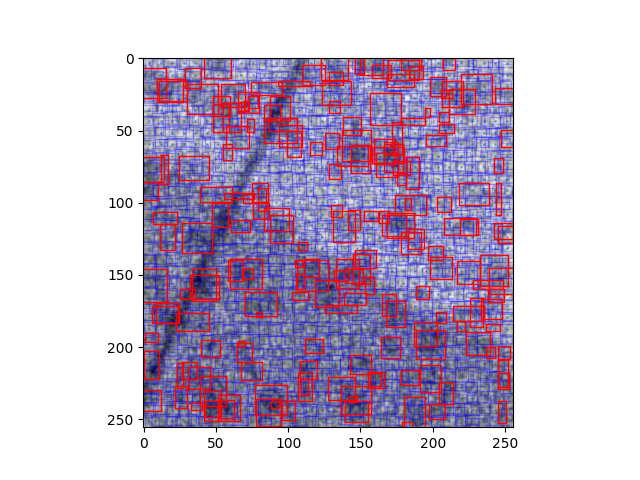

In [7]:
from yolo_help import convert_data

# we need to transform the outputs into bounding boxes
# for this we need a parameterization
# now YOLO assumes a fixed size, which I don't want to do
# my parameterization will therefore be
# xyshift (a number between -0.5 and 0.5, relative to grid size)
# hwscale (relative to grid size, )

# so we need a function to do this transformation
# number of bounding boxes
B = net.B
stride = net.stride
bboxes,data = convert_data(out,B,stride)


fig,ax = plt.subplots()
x = torch.arange(out.shape[-1])*stride + (stride-1)/2
y = torch.arange(out.shape[-2])*stride + (stride-1)/2
YX = torch.stack(torch.meshgrid(y,x,indexing='ij'),0)
ax.imshow(I[0],cmap='gray')
ax.scatter(YX[1].ravel(),YX[0].ravel(),s=1,alpha=0.5)
x = bboxes[...,0]
y = bboxes[...,1]
w = bboxes[...,2]
h = bboxes[...,3]
c = data[...,-1]
predicted_rectangles = bbox_to_rectangles(torch.stack( (x.ravel(),y.ravel(),w.ravel(),h.ravel()) ).T,fc='none',ec='b',alpha=c.clone().detach()*0.5)
ax.add_collection(predicted_rectangles,)

true_rectangles = bbox_to_rectangles(bbox,fc='none',ec='r')
ax.add_collection(true_rectangles,)
fig.canvas.draw()

In [8]:
from yolo_help import get_assignment_inds


# transform the true bounding boxes
# to do this first we need an assignment to a given cell
shape = out.shape
B = net.B

assignment_inds,ious = get_assignment_inds(bboxes,bbox,shape,stride,B)
bboxes_assigned = bboxes[assignment_inds]
x = bboxes_assigned[...,0]
y = bboxes_assigned[...,1]
w = bboxes_assigned[...,2]
h = bboxes_assigned[...,3]
c = data[assignment_inds,-1]
predicted_rectangles = bbox_to_rectangles(torch.stack( (x.ravel(),y.ravel(),w.ravel(),h.ravel()) ).T,fc='none',ec='g',alpha=c.clone().detach())
ax.add_collection(predicted_rectangles,)

In [9]:
from yolo_help import get_reg_targets

# now that we have assignment inds and ious
# we also need the target regression parameters
shape = out.shape
stride = net.stride
B = net.B
    
shape = out.shape
stride = net.stride
B = net.B    
shiftx,shifty,scalex,scaley = get_reg_targets(assignment_inds,bbox,B,shape,stride)

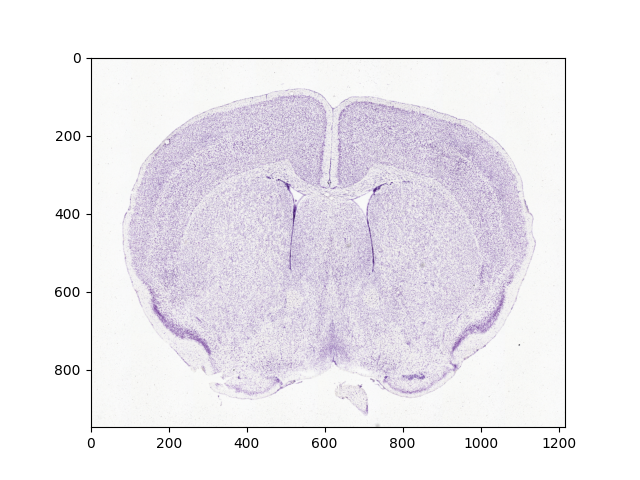

In [10]:
if user == 'abenneck':
    J = plt.imread('/home/abenneck/Desktop/yolo_model/section_000197_30800.jpeg')
else:
    J = plt.imread('/home/dtward/data/AllenInstitute/ARA/section_000197_30800.jpeg')

J= J[...,:3]
if J.dtype == np.uint8:
    J = J / 255.0
J = J.transpose((-1,0,1))
#J = np.mean(J,-1)
fig,ax = plt.subplots()
imshow(J[:,::8,::8],ax)

0.00 seconds for epoch 1499


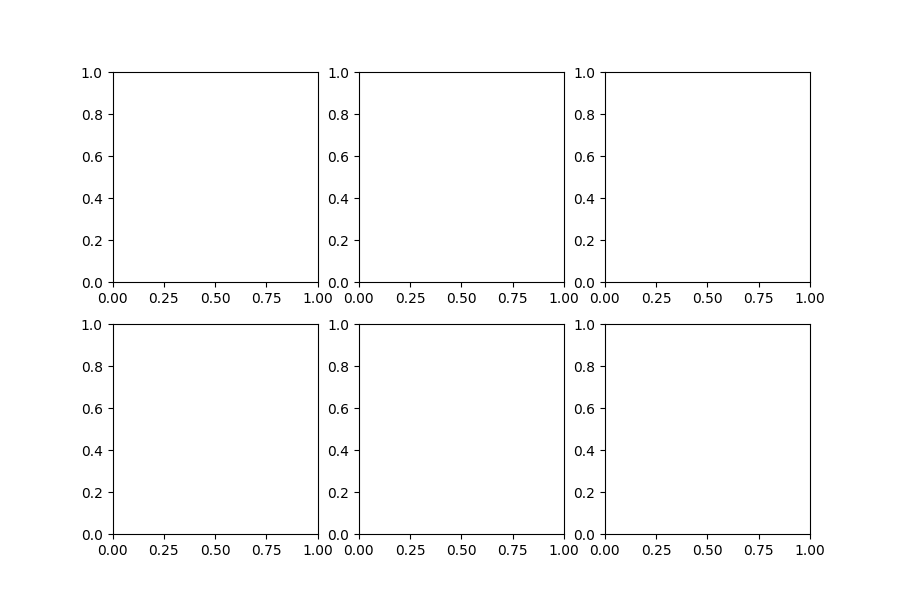

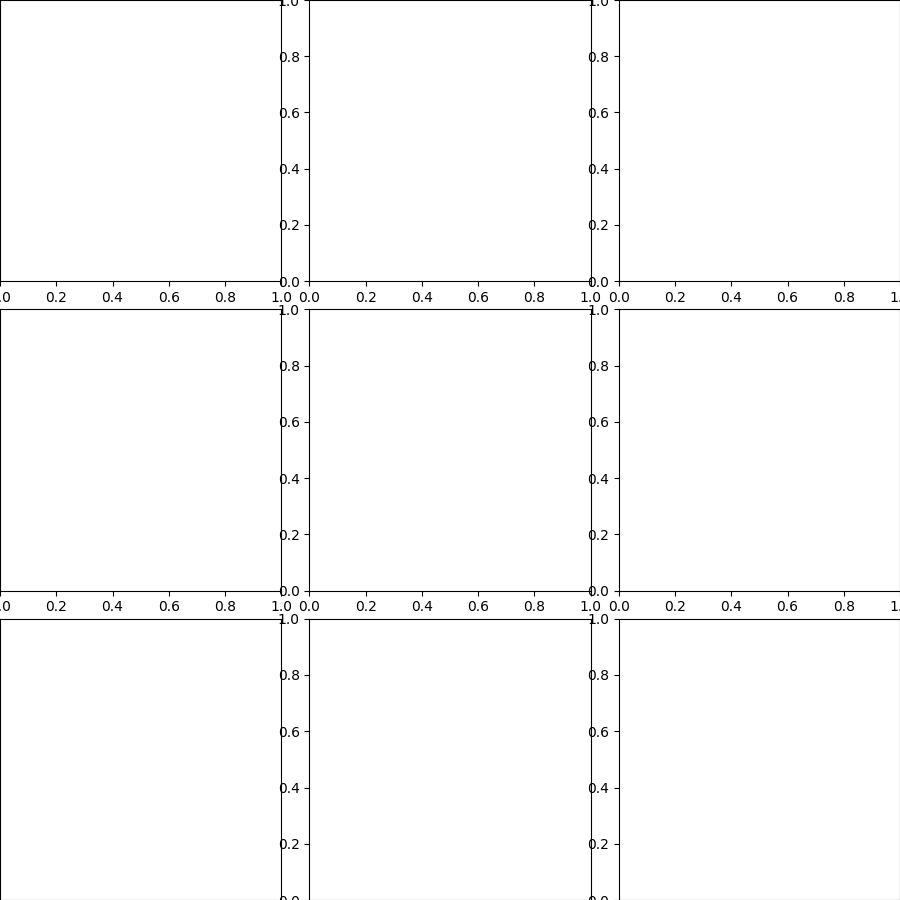

In [11]:
from yolo_help import get_best_bounding_box_per_cell

def train_yolo_model(nepochs, lr, optimizer, cls_loss, outdir, modelname, optimizername, lossname):

    # Check to see that outdir exists and create outdir if it does not exist
    makedirs(outdir,exist_ok=True)
    
    Esave = []
    
    fig,ax = plt.subplots(2,3,figsize=(9,6)) 
    ax = ax.ravel()
    fig1,ax1 = plt.subplots(3,3,figsize=(9,9))
    fig1.subplots_adjust(left=0,right=1,bottom=0,top=1,hspace=0.1,wspace=0.1)
    
    if resume:        
        net.load_state_dict(torch.load(join(outdir,modelname)))
        optimizer.load_state_dict(torch.load(join(outdir,optimizername)))
        #Esave,Ersave,Ecsave = torch.load(join(outdir,lossname))
        Esave = torch.load(join(outdir,lossname))[0]
    for e in range(nepochs):
        start = time.time()
        if resume and e < len(Esave):
            continue
        count = 0
        Esave_ = []    
        for I,bbox,cl in groundtruth:
            optimizer.zero_grad()
            # run through the net
            out = net(torch.tensor(I[None],dtype=torch.float32))
            
            # convert the data into bbox format
            bboxes,data = convert_data(out,net.B,net.stride)
            
            # get assignments
            assignment_inds,ious = get_assignment_inds(bboxes,bbox,out.shape,net.stride,net.B)
            unassigned_inds = np.array([a for a in range(bboxes.shape[0]) if a not in assignment_inds])
            
            
            # get target parameters
            shiftx,shifty,scalex,scaley = get_reg_targets(assignment_inds,bbox,net.B,out.shape,net.stride)    
    
            
            # now build the loss function
            data_assigned = data[assignment_inds]
            targets = np.stack((shiftx,shifty,scalex,scaley,ious),-1)
            
            # this is the mean square error for assigned
            # they used a weight of 0.5 for noobj
            # note that in the paper they used a different loss for the scales (take the square root first)
            Ecoord = torch.sum((data_assigned[:,:4]-torch.tensor(targets[:,:4]))**2)*5
            # if it is assigned ot an object we want to predict the iou
            Eobj = torch.sum((data_assigned[:,-1]-torch.tensor(targets[:,-1]))**2)
            # if there is no object assigned we want to predict 0
            Enoobj = torch.sum((data[unassigned_inds,-1]-0)**2)*0.5
            # and we want to classify
            classprobs = out[:,-nclasses:].reshape(nclasses,-1)
            classprobs_assigned = classprobs[...,assignment_inds%(out.shape[-1]*out.shape[-2])]
            # note the paper uses mean square error on the probability vector
            # here I use cross entropy
            Ec = cls_loss(classprobs_assigned[None],torch.tensor(cl)[None])
            
            #print(Ecoord.item(),Eobj.item(),Enoobj.item(),Ec.item())
            
            E = Ecoord + Eobj + Enoobj + Ec
            
            Esave_.append(E.item())
            
            
            
            E.backward()
            
            optimizer.step()
            
            count += 1
            if count >= len(groundtruth): break
        
        
        
    
        
        # draw        
        Esave.append(np.mean(Esave_))
        #Ersave.append(np.mean(Ersave_))
        #Ecsave.append(np.mean(Ecsave_))
        ax[0].cla()
        ax[0].plot(Esave,label='loss')
        #ax[0].plot(Ersave,label='reg')
        #ax[0].plot(Ecsave,label='cls')
        ax[0].legend()
        ax[0].set_yscale('log')
        ax[0].set_title('training loss')
        
        
        ax[1].cla()
        #ax[1].imshow(I[0],cmap='gray',vmin=0,vmax=1)
        #imshow(I,ax[1],cmap='gray',vmin=0,vmax=1)
        imshow(net.color.out.clone().detach()[0],ax[1])
        ax[1].add_collection(bbox_to_rectangles(bbox,fc='none',ec=[0.5,0.5,0.5,0.5]))
        
        # get better colors
        p = torch.softmax(classprobs.clone().detach(),0)
        c0 = torch.tensor([1.0,0.0,0.0])
        c1 = torch.tensor([0.0,1.0,0.0])
        colors = ( (p[0]*c0[...,None]) + (p[1]*c1[...,None])  ).T.numpy()    
        if nclasses == 3:
            c2 = torch.tensor([0.0,0.0,1.0])
            colors = ( (p[0]*c0[...,None]) + (p[1]*c1[...,None]) + (p[2]*c2[...,None]) ).T.numpy()    
        #colors = colors.repeat(net.B,axis=0)
        
        
        #colors = 'r'
        bboxes_,scores_ = get_best_bounding_box_per_cell(bboxes,data[:,-1].clone().detach(),net.B)
        # TODO: we need to select only one bounding box per cell (the one with the higher predicted IOU)
        ax[1].add_collection(bbox_to_rectangles(bboxes_,fc='none',ec=colors,ls='-',alpha=scores_))
        #ax[1].add_collection(bbox_to_rectangles(bboxes[assignment_inds],fc='none',ec='g',alpha=0.5))
        ax[1].set_title('Annotations')
        
        
        classprob = torch.softmax(out.clone().detach()[0,-nclasses:],0)
        mask = torch.sigmoid(out[0,4].clone().detach())
        ax[2].cla()
        ax[2].imshow(mask,vmin=0,vmax=1,interpolation='gaussian')
        ax[2].set_title('Predicted score (pobj*iou)')
        #mask = mask*0+1
        ax[3].cla()    
        ax[3].imshow(   classprob[0]*mask  ,vmin=0,vmax=1,interpolation='gaussian')
        ax[3].set_title('Class 0 (smooth) prob map')
        
        ax[4].cla()
        ax[4].imshow(   classprob[1]*mask   ,vmin=0,vmax=1,interpolation='gaussian')
        ax[4].set_title('Class 1 (sharp) prob map')
        
        if nclasses == 3:
            ax[5].cla()
            ax[5].imshow(   classprob[2]*mask   ,vmin=0,vmax=1,interpolation='gaussian')
            ax[5].set_title('Class 2 (bumpy) prob map')
        fig.canvas.draw()
        
        
        
        with torch.no_grad():
            #I = plt.imread('/home/dtward/Pictures/Screenshots/Screenshot from 2025-01-14 13-52-23.png')[...,:3]
            #I = plt.imread('/home/dtward/Pictures/Screenshots/Screenshot from 2025-01-14 14-47-18.png')[...,:3]
            #I = np.mean(I,-1)[:256,:256][None]
            net.eval()
            for r in range(3):
                for c in range(3):
                    ax1[r,c].cla()
                    sl = (slice(r*2000+2000,r*2000+2000+256),slice(c*2000+2000,c*2000+2000+256))
                    out = net(torch.tensor(J[(slice(None),)+sl][None],dtype=torch.float32))
    
                    # convert the data into bbox format
                    bboxes,data = convert_data(out,net.B,net.stride)
    
                    #ax1[r,c].imshow(J[sl],cmap='gray')
                    #imshow(J[sl])
                    #imshow(net.color.out.clone().detach()[0],ax1[r,c])
                    imshow(net.color.out.clone().detach()[0],ax1[r,c])
    
                    classprobs = out[:,-nclasses:].reshape(nclasses,-1)
                    p = torch.softmax(classprobs.clone().detach(),0)
                    c0 = torch.tensor([1.0,0.0,0.0])
                    c1 = torch.tensor([0.0,1.0,0.0])
                    #colors = ( (p[0]*c0[...,None]) + (p[1]*c1[...,None]) ).T.numpy()
                    colors = 'r'
                    bboxes_,scores_ = get_best_bounding_box_per_cell(bboxes,data[:,-1].clone().detach(),net.B)
                    alpha = scores_.clone().detach()
                    alpha = alpha * (alpha>0.5)
                    
                    ax1[r,c].add_collection(bbox_to_rectangles(bboxes_,fc='none',ec=colors,ls='-',alpha=alpha))
                    ax1[r,c].axis('off')
            net.train()
        fig1.canvas.draw()
        if not e%10:
            fig1.savefig(join(outdir,f'example_e_{e:06d}.png'))
        
        
        # save data
        torch.save(net.state_dict(),join(outdir,modelname))
        torch.save(optimizer.state_dict(),join(outdir,optimizername))
        #torch.save([Esave,Ersave,Ecsave],join(outdir,lossname))
        torch.save([Esave],join(outdir,lossname))  

    print(f'{time.time() - start:.2f} seconds for epoch {e}')
    start = time.time()
    

nepochs = 1500
lr = 1e-4
optimizer = torch.optim.Adam(net.parameters(),lr=lr)
cls_loss = torch.nn.CrossEntropyLoss(reduction='sum')
resume = True # if True, will load a saved model

modelname = 'modelsave.pt'
optimizername = 'optimizersave.pt'
lossname = 'loss.pt'

if user == 'abenneck':
    outdir = '/home/abenneck/Desktop/YOLO/yolo_saved_models_v01'
else:
    outdir = 'yolo_saved_models_v01'

train_yolo_model(nepochs, lr, optimizer, cls_loss, outdir, modelname, optimizername, lossname)

In [12]:
# What to add
# I wasn't sure if the outputcan make more than one prediction per grid cell in evaluation mode.
# for now we're doing one prediction per grid cell in evaluation mode.
# 1. Set up a repo on twardlab (and add me to it)
# 2. Move all the functions and models into a .py file.  Keep the training in the notebook.  i.e.
#    any time this notebook has a "def" or a "class", that will be replaced by an import statement from 
#   the py file.
# 3. Make another notebook that loads the saved model and does prediction (this is how people will use it).
# 4. Add a tool for doing NMS, and a tool for calculating precision recall curves. Maybe you used an existing 
#    implementation in scikit learn.

## PR Curve Generation

In [94]:
bboxes_,scores_ = get_best_bounding_box_per_cell(bboxes,scores.clone().detach(),net.B)

# NOTE: This function is only called when arr_ is guaranteed to be an element of list_
def remove_arr_from_list(list_, arr_):
    list_ = list(list_)
    for i, elem in enumerate(list_):
        if np.array_equal(elem, arr_):
            list_.pop(i)
            break
    

    return list_

print(len(bboxes_))
bboxes_ = remove_arr_from_list(bboxes_, bboxes_[10])
print(len(bboxes_))

1024
1023


In [137]:
def NMS(bboxes_, scores_, nms_threshold = 0.5):

    bboxes_nms = [b for _ , b in sorted(zip(scores_, bboxes_), reverse = True)]
    scores_nms = sorted(scores_, reverse = True)

    bboxes_out = []
    scores_out = []
    
    count = 0
    while len(bboxes_nms) > 0:
        for b_max, s_max in zip(bboxes_nms, scores_nms):
            # Append bbox w highest scores to output list + remove from input list
            bboxes_out.append(b_max)
            bboxes_nms = remove_arr_from_list(bboxes_nms, b_max)
            scores_out.append(s_max)
            scores_nms.remove(s_max)
            print(f'Appended ({b_max},{s_max})')

            # Remove bbox if iou w b_max > nms_threshold
            for b,s in zip(bboxes_nms, scores_nms):
                if iou(b_max, b) > nms_threshold:
                    bboxes_nms = remove_arr_from_list(bboxes_nms, b)
                    scores_nms.remove(s)
                    count += 1
                    print(f'Removed ({b},{s})')
            print(f'Removed {count} total boxes')
        break
    
    return bboxes_out, scores_out

bboxes_,scores_ = get_best_bounding_box_per_cell(bboxes,scores.clone().detach(),net.B)

def remove_low_conf_bbox(bboxes_, scores_, conf_threshold = 0.1):

    # Sort the input arrays
    bboxes_conf = np.array([b for _ , b in sorted(zip(scores_, bboxes_), reverse = True)])
    scores_conf = np.array([s.numpy().item() for s in sorted(scores_, reverse = True)])

    # Remove all elements of the arrays where the score is below 'conf_threshold'
    bboxes_conf = bboxes_conf[scores_conf >= conf_threshold]
    scores_conf = scores_conf[scores_conf >= conf_threshold]

    # Convert numpy arrays back to torch tensors
    bboxes_conf = torch.from_numpy(bboxes_conf)
    scores_conf = torch.from_numpy(scores_conf)
    
    return bboxes_conf, scores_conf

print(bboxes_[0])
NMS(bboxes_, scores_)
print(bboxes_[0])

tensor([0.4827, 2.0520, 9.1629, 9.0142])
Appended (tensor([11.4365, 66.8096,  5.2228, 19.7990]),0.9999617338180542)
Removed 0 total boxes
Appended (tensor([125.5013,  51.9900,   9.9094,  10.4427]),0.995732843875885)
Removed 0 total boxes
Appended (tensor([218.4993,  86.0738,  20.6288,  15.3123]),0.9947086572647095)
Removed 0 total boxes
Appended (tensor([207.6908, 110.7144,  22.2960,  11.9180]),0.993216335773468)
Removed 0 total boxes
Appended (tensor([ -6.6743, 146.0808,  22.8327,  22.7759]),0.9928662776947021)
Removed 0 total boxes
Appended (tensor([ 88.1037, 237.2752,   5.2376,   5.1047]),0.9886188507080078)
Removed 0 total boxes
Appended (tensor([54.8849, 30.8888, 12.5160, 20.0728]),0.9859625697135925)
Removed 0 total boxes
Appended (tensor([238.7824, 145.5106,  20.6411,  17.4930]),0.9855255484580994)
Removed (tensor([239.8481, 140.7305,  17.8335,  19.3861]),5.2085895682228364e-14)
Removed 1 total boxes
Appended (tensor([ 77.0899, 226.1363,  22.1165,  20.8666]),0.9839805960655212)


KeyboardInterrupt: 

In [132]:
from sklearn.metrics import precision_recall_curve

# bbox = [cx, cy, w, h, conf]
I,bbox,cls = groundtruth[0]
out = net(torch.tensor(I,dtype=dtype)[None])
bboxes,data = convert_data(out,net.B,net.stride)
scores = data[:,-1]

# Reduces # of guesses by factor of 2
bboxes_,scores_ = get_best_bounding_box_per_cell(bboxes,scores.clone().detach(),net.B)

# Remove low confidence guesses
bboxes_,scores_ = remove_low_conf_bbox(bboxes_,scores_)

# Perform NMS on filtered guesses
bboxes_,scores_ = NMS(bboxes_, scores_)

iou_threshold  = [round(x,2) for x in list(np.arange(0.5,1.0,0.05))]
conf_threshold = [round(x,2) for x in list(np.arange(0,1.0,0.01))]

# for iou in iou_threshold:
#     for conf in conf_threshold:
#         for bbox in bboxes:


tensor([0.4827, 2.0520, 9.1629, 9.0142])
1024
166
Appended ([11.436468 66.80957   5.222769 19.798979],0.9999617338180542)
Removed 0 total boxes
Appended ([125.50129   51.989998   9.909383  10.442699],0.9947086572647095)
Removed 0 total boxes
Appended ([218.4993    86.07381   20.628784  15.312252],0.9928662776947021)
Removed 0 total boxes
Appended ([207.6908   110.71442   22.295961  11.918008],0.9859625697135925)
Removed 0 total boxes
Appended ([ -6.67429 146.08084  22.83271  22.77593],0.9839805960655212)
Removed 0 total boxes
Appended ([ 88.10369   237.27522     5.2376375   5.1047215],0.9826858043670654)
Removed 0 total boxes
Appended ([54.88489  30.888777 12.516045 20.072842],0.9815334677696228)
Removed 0 total boxes
Appended ([238.78236  145.51062   20.641083  17.492952],0.9807595610618591)
Removed 0 total boxes
Appended ([ 77.08987  226.13628   22.116545  20.86659 ],0.9796605706214905)
Removed ([ 77.656395 227.34094   18.818476  19.195536],4.4912334828950407e-07)
Removed 1 total box

### Daniel's Scratch Work

In [ ]:
import tifffile
K = tifffile.imread('/panfs/dong/RNAscope/SW230926-02A/TIFFS/SW230926-02A_1_16.tif')
K = K / np.max(K,axis=(-1,-2),keepdims=True)
K = K[...,::2,::2]
#K = K[0,None]
print(K.shape)

In [ ]:
fig,ax= plt.subplots()
imshow(K[...,::8,::8],ax)

In [ ]:
# another image to try
fig2,ax2 = plt.subplots(3,3,figsize=(9,9))
fig2.subplots_adjust(left=0,right=1,bottom=0,top=1,hspace=0.1,wspace=0.1)

net.eval()
n = 128
stride = 1024
for r in range(3):
    for c in range(3):
        ax1[r,c].cla()
        sl = (slice(r*stride+stride,r*stride+stride+n),slice(c*stride+stride,c*stride+stride+n))
        out = net(torch.tensor(K[(slice(None),)+sl][None],dtype=torch.float32))

        # convert the data into bbox format
        bboxes,data = convert_data(out,net.B,net.stride)

        #ax1[r,c].imshow(J[sl],cmap='gray')
        #imshow(K[sl],ax2[r,c])
        #imshow(net.color.out.clone().detach()[0],ax1[r,c])
        imshow(net.color.out.clone().detach()[0],ax2[r,c])

        classprobs = out[:,-nclasses:].reshape(nclasses,-1)
        p = torch.softmax(classprobs.clone().detach(),0)
        c0 = torch.tensor([1.0,0.0,0.0])
        c1 = torch.tensor([0.0,1.0,0.0])
        #colors = ( (p[0]*c0[...,None]) + (p[1]*c1[...,None]) ).T.numpy()
        colors = 'r'
        bboxes_,scores_ = get_best_bounding_box_per_cell(bboxes,data[:,-1].clone().detach(),net.B)
        alpha = scores_.clone().detach()
        alpha = alpha * (alpha>0.5)

        ax2[r,c].add_collection(bbox_to_rectangles(bboxes_,fc='none',ec=colors,ls='-',alpha=alpha))
        ax2[r,c].axis('off')
net.train()



In [ ]:
# below here is scratch
asdf

In [ ]:
out = net(torch.tensor(J[(slice(None),)+sl][None],dtype=torch.float32))

In [ ]:
fig,ax = plt.subplots()
imshow(net.color.out.clone().detach()[0],ax)

In [ ]:
Esave

In [ ]:
fig,ax = plt.subplots()
ax.hist(mask.numpy().ravel())

In [36]:
colors = ( (p[0]*c0[...,None]) + (p[1]*c1[...,None]) ).T.numpy()

NameError: name 'p' is not defined

In [ ]:
colors.shape

In [ ]:
bboxes.shape,data[:,-1].shape

In [ ]:
I.shape

In [ ]:
data_assigned.shape,shiftx.shape

In [ ]:
data.shape,shiftx.shape

In [ ]:
I,bbox,cl = groundtruth[0]
fig,ax = plt.subplots()
imshow(I,ax)

In [ ]:
I.shape

NameError: name 'colors' is not defined

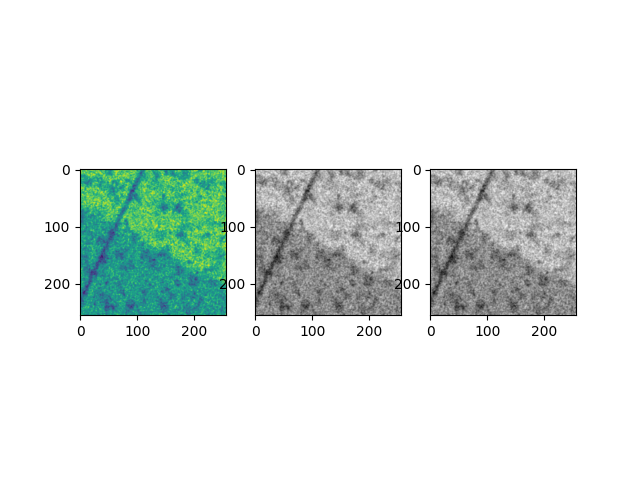

In [35]:
I,bbox,cls = groundtruth[0]
out = net(torch.tensor(I,dtype=dtype)[None])
bboxes,data = convert_data(out,net.B,net.stride)
fig,ax = plt.subplots(1,3)
imshow(I,ax[0])
imshow(net.color.out.clone().detach()[0][0:],ax[1])
imshow(net.color.out.clone().detach()[0][0:],ax[2])

'''
scores = data[:,-1]
scores_ = scores.reshape(-1,B)
inds = torch.argmax(scores_,-1)
scores_ = torch.take_along_dim(scores_,inds[:,None],1)[...,0]

bboxes_ = bboxes.reshape(-1,B,4)
bboxes_ = torch.take_along_dim(bboxes_,inds[:,None,None],1)[:,0]
'''

scores = data[:,-1].clone().detach()

bboxes_,scores_ = get_best_bounding_box_per_cell(bboxes,scores,B)



ax[2].add_collection(bbox_to_rectangles(bboxes_,fc='none',ec=colors,ls='-',alpha=scores_.clone().detach()))


In [ ]:
a = np.random.randn(2,10)
b = np.random.randint(0,2,10)

In [ ]:
a,b

In [ ]:
np.take_along_axis(a,b[None],axis=0).shape

In [ ]:
a.shape,b.shape

In [ ]:
bboxes_.shape

In [ ]:
out